# Convert CREW to Seisbench

Most of the meatadata entries in CREW follow the Seisbench convention but in order to make it fully compatible the format has to be totally changed. This notebook is based on the code over there: https://github.com/seisbench/seisbench/blob/main/examples/03b_creating_a_dataset.ipynb

In [164]:
import skynet; import numpy as np; import matplotlib.pyplot as plt

import seisbench
import seisbench.data as sbd
import seisbench.util as sbu

from pathlib import Path

In [82]:
data=skynet.open('156_CREW.hdf5')
names=list(data.keys())

In [163]:
# open the data file without using skynet
import h5py
f = h5py.File('156_CREW.hdf5','r')
data = f['data']
names=list(data.keys())

In [83]:
base_path = Path("seisbench_conversion")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"

In [112]:
def get_trace_params(example):
    
    component_order = example.attrs['channels'][0][-1]+example.attrs['channels'][1][-1]+example.attrs['channels'][2][-1]
    
    # we do not have location codes from the catalogs
    trace_params = {
        "station_network_code":  example.attrs['station_network_code'],
        "station_code":          example.attrs['station_code'],
        "trace_channel":         example.attrs['channels'][0][:2],
        "station_location_code": '',
        "component_order":       component_order,
        "station_elevation_m":   example.attrs['station_elevation_m'],
        "station_longitude_deg": example.attrs['station_longitude_deg'],
        "station_latitude_deg":  example.attrs['station_latitude_deg'],
        "trace_sampling_rate_hz": 100,
        "trace_category":          example.attrs['trace_category'],
        "trace_P_arrival_sample"  : example.attrs['P_arrival_sample'],
        "trace_Pg_arrival_sample" : example.attrs['Pg_arrival_sample'],
        "trace_Pn_arrival_sample" : example.attrs['Pn_arrival_sample'],
        "trace_S_arrival_sample"  : example.attrs['S_arrival_sample'],
        "trace_Sn_arrival_sample" : example.attrs['Sn_arrival_sample'],
        "trace_Sg_arrival_sample" : example.attrs['Sg_arrival_sample'],
        "trace_name"              : example.name.split('/')[-1]
    }
    return trace_params
get_trace_params(example)

{'station_network_code': 'PM',
 'station_code': 'PESTR',
 'trace_channel': 'BH',
 'station_location_code': '',
 'component_order': 'ENZ',
 'station_elevation_m': 410.0,
 'station_longitude_deg': -7.590169,
 'station_latitude_deg': 38.867168,
 'trace_sampling_rate_hz': 100,
 'trace_category': 'earthquake',
 'trace_P_arrival_sample': 11941.5,
 'trace_Pg_arrival_sample': 'NaN',
 'trace_Pn_arrival_sample': 'NaN',
 'trace_S_arrival_sample': 17143.5,
 'trace_Sn_arrival_sample': 'NaN',
 'trace_Sg_arrival_sample': 'NaN',
 'trace_name': 'PM.PESTR.BH_origid=616409488'}

In [153]:
def get_event_params(example):

    event_params = {
        "source_id":               example.attrs['source_id'],
        "source_origin_time":      example.attrs['source_origin_time'],
        "source_latitude_deg":     example.attrs['source_latitude_deg'],
        "source_longitude_deg":    example.attrs['source_longitude_deg'],
        "source_depth_km":         example.attrs['source_depth_km'],
        "source_magnitude":        example.attrs['source_magnitude'],
        "split":                   'test',
        "path_epicentral_distance_deg": example.attrs['path_ep_distance_deg']
    }
    
    return event_params

get_event_params(example)

{'source_id': 'origid=616409488',
 'source_origin_time': '2022-03-21T22:24:03.010000Z',
 'source_latitude_deg': 35.4044,
 'source_longitude_deg': -3.6313,
 'source_depth_km': 1.9,
 'source_magnitude': 3.2,
 'split': 'test',
 'path_epicentral_distance_deg': 4.685}

In [139]:
# Here we will loop over the first 100 examples only, to keep this small

with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:
    
    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ENZ",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    
    for name in names[:100]:
        example      = data[name]
        event_params = get_event_params(example)
        trace_params = get_trace_params(example)
        tdata        = example[()]
        
        writer.add_trace({**event_params, **trace_params}, tdata)
 

Traces converted: 100it [00:00, 164.87it/s]


In [168]:
# The resulting dataset is located here:
print(base_path,waveforms_path,metadata_path)

seisbench_conversion seisbench_conversion/waveforms.hdf5 seisbench_conversion/metadata.csv


In [140]:
# load the resulting datase the Seisbench way
sdata = sbd.WaveformDataset(base_path)

In [141]:
sdata.metadata

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,split,station_network_code,station_code,...,trace_P_arrival_sample,trace_Pg_arrival_sample,trace_Pn_arrival_sample,trace_S_arrival_sample,trace_Sn_arrival_sample,trace_Sg_arrival_sample,trace_name,trace_name_original,trace_chunk,trace_component_order
0,0,origid=618808706,2022-07-07T16:19:51.810000Z,50.2498,19.1241,0.0,3.30,train,PL,NIE,...,NaN,11409.7001,NaN,NaN,NaN,13141.7001,"bucket0$0,:3,:30000",PL.NIE.BH_origid=618808706,,ENZ
1,1,origid=618811604,2022-07-08T17:34:15.830000Z,50.4720,18.5007,0.0,3.10,train,PL,NIE,...,NaN,9527.5000,NaN,NaN,NaN,11444.5000,"bucket0$1,:3,:30000",PL.NIE.BH_origid=618811604,,ENZ
2,2,origid=618827317,2022-02-07T19:34:29.500000Z,50.1900,19.0920,2.0,3.80,train,PL,NIE,...,NaN,11918.1000,NaN,NaN,NaN,13536.1000,"bucket0$2,:3,:30000",PL.NIE.BH_origid=618827317,,ENZ
3,3,origid=618828408,2022-03-29T21:29:43.420000Z,50.0940,18.4220,10.0,2.98,train,PL,NIE,...,10007.5,9981.5000,NaN,11964.5,NaN,12012.5000,"bucket0$3,:3,:30000",PL.NIE.BH_origid=618828408,,ENZ
4,4,origid=618829035,2022-04-23T01:39:41.580000Z,50.0390,18.5930,1.0,2.94,train,PL,NIE,...,9788.2,9805.2000,NaN,NaN,NaN,11605.2000,"bucket0$4,:3,:30000",PL.NIE.BH_origid=618829035,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,origid=616395049,2022-03-08T08:22:24.220000Z,35.5798,-3.5725,16.0,3.20,train,PM,PESTR,...,9651.5,NaN,NaN,14715.5,NaN,NaN,"bucket0$95,:3,:30000",PM.PESTR.BH_origid=616395049,,ENZ
96,96,origid=616397684,2022-03-12T01:57:57.810000Z,34.9799,-3.8976,8.4,3.30,train,PM,PESTR,...,11389.5,NaN,11319.5,16671.5,16738.5,NaN,"bucket0$96,:3,:30000",PM.PESTR.BH_origid=616397684,,ENZ
97,97,origid=616397953,2022-03-13T20:08:01.630000Z,36.2570,-5.8482,59.5,4.40,train,PM,PESTR,...,10137.5,NaN,10132.5,13326.5,13281.5,NaN,"bucket0$97,:3,:30000",PM.PESTR.BH_origid=616397953,,ENZ
98,98,origid=616408780,2022-03-20T06:47:11.420000Z,42.8045,-1.0486,1.0,3.50,train,PM,PESTR,...,9259.5,NaN,9337.5,16343.5,16253.5,20546.5000,"bucket0$98,:3,:30000",PM.PESTR.BH_origid=616408780,,ENZ


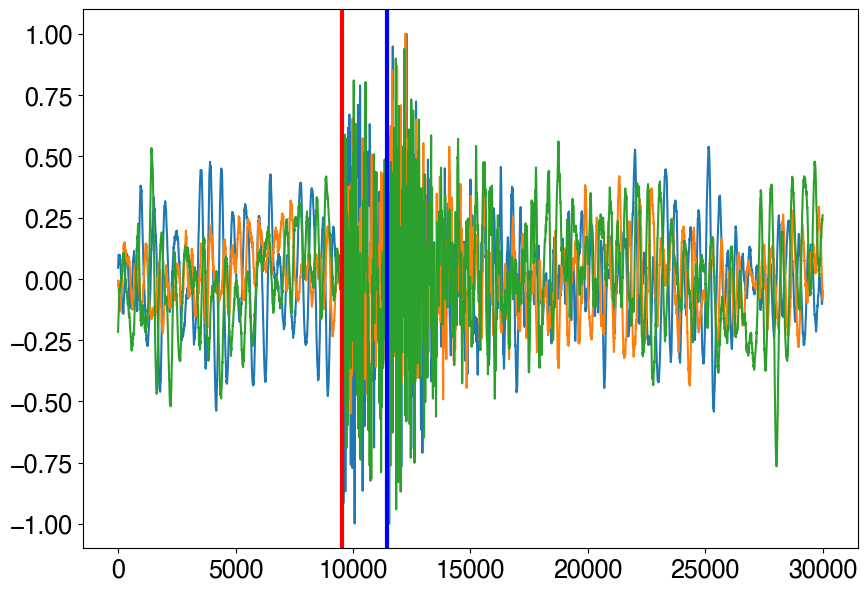

In [165]:
# plot an example
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

index=1 # change this number to get a different example
ax.plot(sdata.get_waveforms(index).T)
ax.axvline(sdata.metadata["trace_Pg_arrival_sample"].iloc[index], color="r", lw=3)
ax.axvline(sdata.metadata["trace_Sg_arrival_sample"].iloc[index], color="b", lw=3)
ax.axvline(sdata.metadata["trace_P_arrival_sample"].iloc[index], color="r", lw=3)
ax.axvline(sdata.metadata["trace_S_arrival_sample"].iloc[index], color="b", lw=3)
ax.axvline(sdata.metadata["trace_Pn_arrival_sample"].iloc[index], color="r", lw=3)
ax.axvline(sdata.metadata["trace_Sn_arrival_sample"].iloc[index], color="b", lw=3)

# Note: The waveforms in CREW were zero padded when necessary to ensure the 5 minute duration, especially at the end. Here some examples
## Note that the final seconds of the waveform are flat, which is the padded part

In [3]:
def count_zeros(example):
    X = example[()]
    count = X[np.abs(X)<1e-10].shape[0]
    return count

In [17]:
for name in names:
    example=data[name]
    count = count_zeros(example)
    if count>100:
        print(name,count)

PQ.NBC5.HH_origid=616387606 9108
RV.WTMTA.HH_origid=616387606 1112


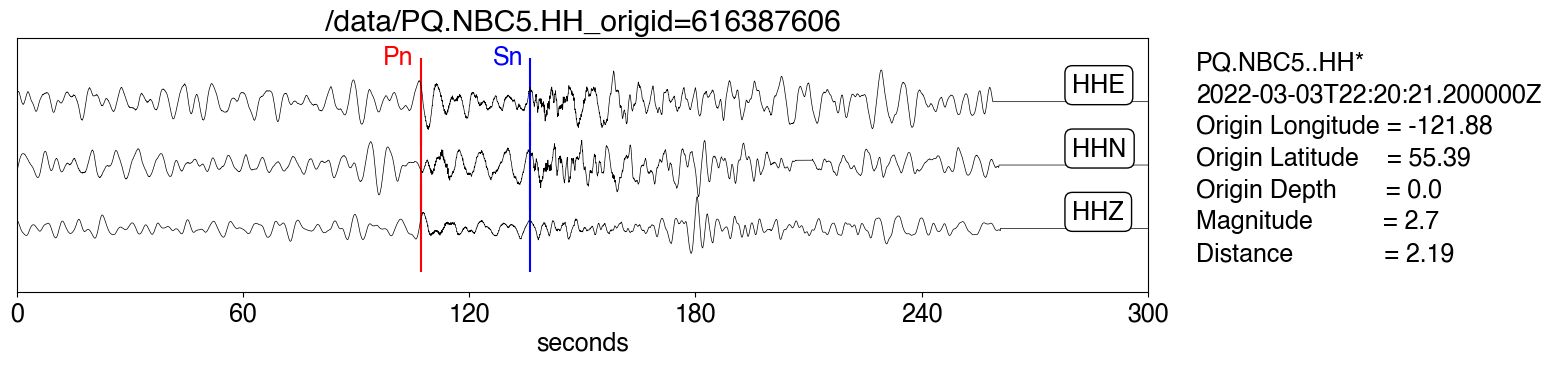

In [16]:
example=data['PQ.NBC5.HH_origid=616387606']
plot=skynet.plot_example_long(example)

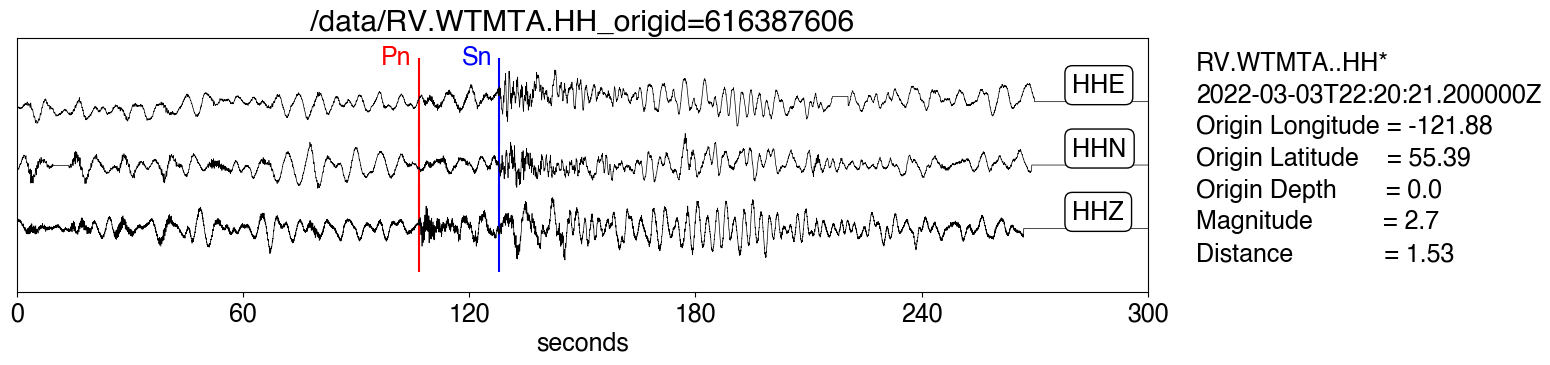

In [20]:
example=data['RV.WTMTA.HH_origid=616387606']
plot=skynet.plot_example_long(example)